## Crawl Detik

Program ini, "Detik News Scraper", dirancang untuk mengambil informasi dari situs detik.com terkait topik berita yang diinginkan. Pengguna memasukkan topik, program mengambil URL berita, dan kemudian ekstrak informasi seperti judul, penulis, tanggal, dan isi berita.

In [16]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import json

class Detik:
    def __init__(self, topic):
        self.topic = topic
        self.df = None  # Inisialisasi DataFrame sebagai None

    def get_urls(self):
        news_links = []
        # get news URL from page 1
        page = 1
        url = f"https://www.detik.com/search/searchall?query={self.topic}&siteid=2&sortby=time&page={page}"
        html_page = requests.get(url).content
        soup = BeautifulSoup(html_page, 'lxml')
        articles = soup.find_all('article')

        # Ambil hanya satu URL berita, jika ada
        if articles:
            url = articles[0].find('a')['href']
            news_links.append(url)

        return news_links

    def has_link(self, text):
        # Fungsi untuk memeriksa apakah teks mengandung tautan
        return 'href=' in text

    def extract_news(self):
        # get news article details from scraped URLs
        scraped_info = []
        for news in self.get_urls():
            source = news
            html_page = requests.get(news).content
            soup = BeautifulSoup(html_page, 'lxml')
            # check if title, author, date, news div, is not None type
            title = soup.find('h1', class_='detail__title')
            if title is not None:
                title = title.text
                title = title.replace('\n', '')
                title = title.strip()

            author = soup.find('div', class_='detail__author')
            if author is not None:
                author = author.text

            date = soup.find('div', class_='detail__date')
            if date is not None:
                date = date.text

            # Ambil isi berita dari div dengan class 'detail__body-text itp_bodycontent'
            content_div = soup.find("div", {"class": "detail__body-text itp_bodycontent"})
            if content_div:
                # Hilangkan elemen-elemen <a> yang merupakan tautan
                for a_tag in content_div.find_all(self.has_link):
                    a_tag.decompose()

                # Ambil teks dari div
                news_content = ' '.join(content_div.stripped_strings)

                # convert scraped data into a dictionary
                news_data = {
                    "url": source,
                    "judul": title,
                    "penulis": author,
                    "tanggal": date,
                    "isi": news_content
                }
                # add dictionaries to a list
                scraped_info.append(news_data)

        self.df = pd.DataFrame.from_dict(scraped_info)
        self.df.to_csv(f'{self.topic}.csv', index=False)  # Simpan DataFrame ke dalam file CSV

# Input topik berita
topic = input("Masukkan topik berita yang ingin diambil: ")
detik_crawler = Detik(topic)
detik_crawler.extract_news()

# Setelah DataFrame df dibuat dalam metode extract_news, Anda dapat mengaksesnya di sini
detik_crawler.df


Masukkan topik berita yang ingin diambil: OLAHRAGA


,url,judul,penulis,tanggal,isi
0,https://www.detik.com/jabar/berita/d-7046257/1...,100 Rekomendasi Nama Bayi Sunda Perempuan Isla...,Mentari Nurmalia - detikJabar,"Selasa, 21 Nov 2023 06:30 WIB",Bandung - Setiap nama yang diberikan pada anak...


## Ekstraksi Kalimat

In [17]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
import re
import string

nltk.download('punkt')
nltk.download('stopwords')

# Mendapatkan daftar stop words dalam bahasa Indonesia
stop_words = set(stopwords.words('indonesian'))

# Fungsi untuk melakukan tokenisasi kata, konversi ke huruf kecil, dan menghapus tanda baca dan angka
def extract_and_preprocess_words(text):
    words = word_tokenize(text)
    preprocessed_words = [word.lower() for word in words if (word.isalpha() and word.lower() not in stop_words)]

    return preprocessed_words

# Buat DataFrame baru untuk kata-kata
kata_df = pd.DataFrame(columns=['berita_id', 'kata'])

# Ekstrak dan proses setiap berita
for i in range(len(detik_crawler.df)):
    berita_id = i
    berita = detik_crawler.df.loc[i, 'isi']
    kata_berita = extract_and_preprocess_words(berita)

    # Tambahkan setiap kata ke DataFrame
    for kata in kata_berita:
        kata_df = pd.concat([kata_df, pd.DataFrame({'berita_id': [berita_id], 'kata': [kata]})], ignore_index=True)

# Tampilkan DataFrame dengan kolom 'berita_id' dan 'kata'
print(kata_df[['berita_id', 'kata']])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


    berita_id     kata
0           0  bandung
1           0     nama
2           0     anak
3           0      doa
4           0  harapan
..        ...      ...
450         0     bayi
451         0    sunda
452         0     nama
453         0    sunda
454         0    sunda

[455 rows x 2 columns]


## TF-IDF

## Membentuk Graph

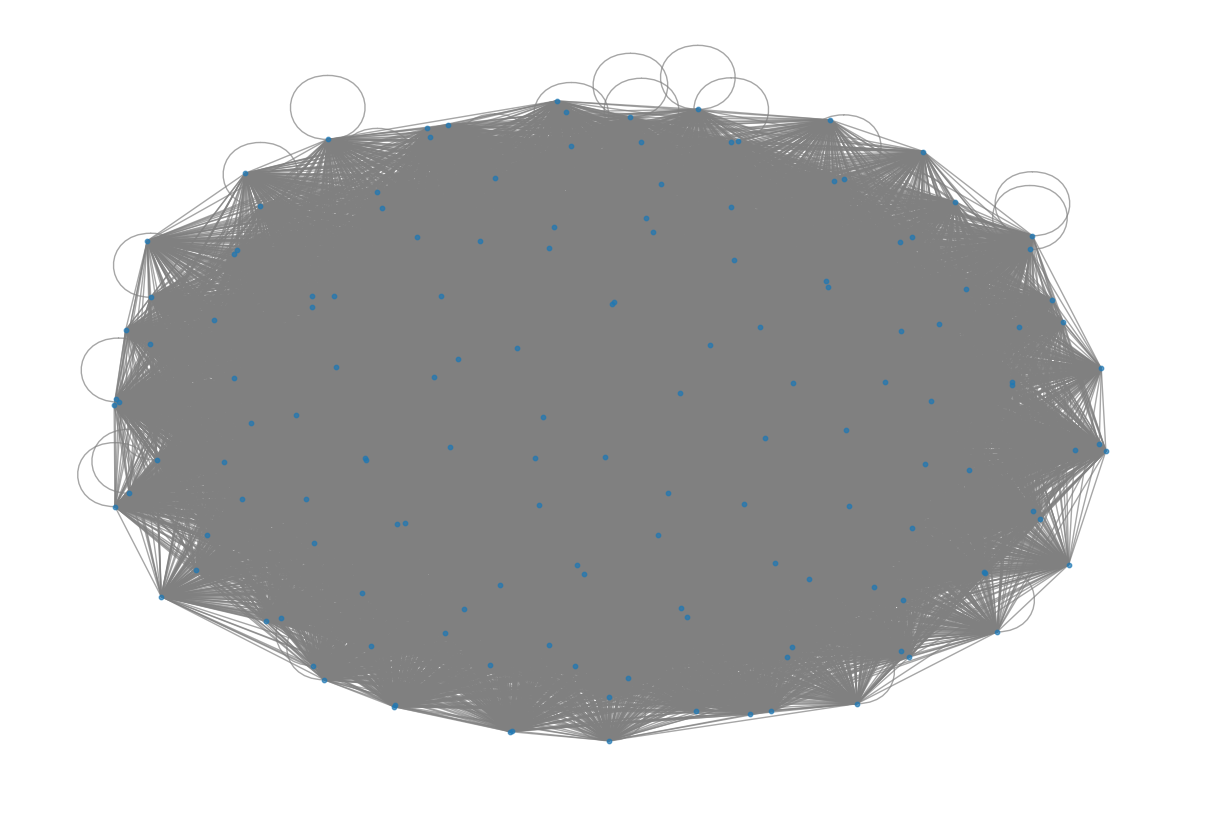

In [15]:
import networkx as nx
import matplotlib.pyplot as plt

# Buat graf
G = nx.Graph()

# Tambahkan tepi (edge) antara kata-kata
for i in range(len(kata_df)):
    for j in range(i + 1, len(kata_df)):  # Hindari menghitung skor untuk diri sendiri dan duplikat
        kata_i = kata_df.loc[i, 'kata']
        kata_j = kata_df.loc[j, 'kata']

        G.add_edge(kata_i, kata_j)

# Gambar graf
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=False, node_size=10, edge_color='gray', alpha=0.7)
plt.show()


## Closeness, Eigenvector, Pagerank, Betweenness Centrality

In [ ]:
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)
pagerank_centrality = nx.pagerank(G)
betweenness_centrality = nx.pagerank(G)

## Closeness Centrality

In [ ]:
# Tampilkan closeness centrality dari nilai tertinggi ke terendah
sorted_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)

print("Closeness Similarity Scores (Dari Tertinggi ke Terendah):")
for node, score in sorted_closeness:
    print(f"{node}: {score}")

# Tampilkan 3 kalimat teratas dari nilai tertinggi
top_3_nodes = sorted_closeness[:3]

print("Tiga Kalimat Teratas dari Nilai Tertinggi Closeness Centrality:")
for node, _ in top_3_nodes:
    kalimat_index = int(node.split("#")[1])  # Mendapatkan indeks kalimat dari simpul
    kalimat = kalimat_df['kalimat'][kalimat_index]
    print(f"Kalimat #{kalimat_index}: {kalimat}")


## Pagerank Centrality

In [ ]:
sorted_pagerank = sorted(pagerank_centrality.items(), key=lambda x: x[1], reverse=True)

print("Pagerank Scores (Dari Tertinggi ke Terendah):")
for node, score in sorted_pagerank:
    print(f"{node}: {score}")

# Tampilkan 3 kalimat teratas dari nilai tertinggi
top_3_nodes = sorted_pagerank[:3]

print("Tiga Kalimat Teratas dari Nilai Tertinggi Closeness Centrality:")
for node, _ in top_3_nodes:
    kalimat_index = int(node.split("#")[1])  # Mendapatkan indeks kalimat dari simpul
    kalimat = kalimat_df['kalimat'][kalimat_index]
    print(f"Kalimat #{kalimat_index}: {kalimat}")

## Eigenvector Centrality

In [ ]:
sorted_eigenvector = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)

print("eigenvector Scores (Dari Tertinggi ke Terendah):")
for node, score in sorted_eigenvector:
    print(f"{node}: {score}")

# Tampilkan 3 kalimat teratas dari nilai tertinggi
top_3_nodes = sorted_pagerank[:3]

print("Tiga Kalimat Teratas dari Nilai Tertinggi Closeness Centrality:")
for node, _ in top_3_nodes:
    kalimat_index = int(node.split("#")[1])  # Mendapatkan indeks kalimat dari simpul
    kalimat = kalimat_df['kalimat'][kalimat_index]
    print(f"Kalimat #{kalimat_index}: {kalimat}")

## Betweenes Centrality

In [ ]:
sorted_betweeness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)

print("eigenvector Scores (Dari Tertinggi ke Terendah):")
for node, score in sorted_betweeness:
    print(f"{node}: {score}")

# Tampilkan 3 kalimat teratas dari nilai tertinggi
top_3_nodes = sorted_betweeness[:3]

print("Tiga Kalimat Teratas dari Nilai Tertinggi Closeness Centrality:")
for node, _ in top_3_nodes:
    kalimat_index = int(node.split("#")[1])  # Mendapatkan indeks kalimat dari simpul
    kalimat = kalimat_df['kalimat'][kalimat_index]
    print(f"Kalimat #{kalimat_index}: {kalimat}")


